# Обеспеченность Москвы инфраструктурой

Визуализация и анализ данных части инфраструктуры Москвы (спортзалы, велопарковки и площадки для собак) в разрезе данных о населении районов (плотность начеления, площадь жилого фонда, жилплощадь на человека и т.д.).

In [1]:
# Загрузка библиотек и модуля functions
import getpass
import json
import re

import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
from keplergl import KeplerGl

import functions as f



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

c:\Users\Art\VSCodeProjects\test\bi_project\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Задаем константы
API_KEY = getpass.getpass("data.mos.ru API Key:") # получение ключа API от пользователя
DOMAIN = 'https://apidata.mos.ru/v1/datasets/'

### Загрузка и предобработка данных

##### Данные [data.mos.ru](https://data.mos.ru/ "Ссылка на Портал открытых данных правительства Москвы") 

In [3]:
# Запросы по API
bikeparks = f.get_api_data_mos_ru(API_KEY, DOMAIN, '916') # скачиваем датасет про велопарковки
dogparks = f.get_api_data_mos_ru(API_KEY, DOMAIN, '2663') # скачиваем датасет про площадки для собак
gyms  = f.get_api_data_mos_ru(API_KEY, DOMAIN, '60622') # скачиваем датасет про спортивные залы

Датасет №916
Изначально элементов в датасете: 1207
1000
207
Получено элементов: 1207

Датасет №2663
Изначально элементов в датасете: 616
616
Получено элементов: 616

Датасет №60622
Изначально элементов в датасете: 3093
1000
229
0
0
Получено элементов: 1229



In [4]:
# Функция проверки необходимых нам атрибутов
dict_data = {'916' : bikeparks, '2663' : dogparks, '60622' : gyms} # создаем словарь с ключами из номеров датасета
for i in dict_data.keys():
    for substr in ['admarea', 'district', 'geodata', 'lighting', 'address', 'capacity', 'workinghours']:
        y,n = 0,0
        for element in dict_data[i]:
            if  any(re.match(substr, attr, re.IGNORECASE) for attr in element['Cells']):
                y+=1
            else:
                n+=1
        print(f'{i}, {substr} (да: {y}, нет: {n})')

916, admarea (да: 1207, нет: 0)
916, district (да: 1207, нет: 0)
916, geodata (да: 1207, нет: 0)
916, lighting (да: 0, нет: 1207)
916, address (да: 1207, нет: 0)
916, capacity (да: 1207, нет: 0)
916, workinghours (да: 0, нет: 1207)
2663, admarea (да: 616, нет: 0)
2663, district (да: 616, нет: 0)
2663, geodata (да: 616, нет: 0)
2663, lighting (да: 616, нет: 0)
2663, address (да: 0, нет: 616)
2663, capacity (да: 0, нет: 616)
2663, workinghours (да: 616, нет: 0)
60622, admarea (да: 1229, нет: 0)
60622, district (да: 1229, нет: 0)
60622, geodata (да: 1229, нет: 0)
60622, lighting (да: 1229, нет: 0)
60622, address (да: 1229, нет: 0)
60622, capacity (да: 0, нет: 1229)
60622, workinghours (да: 1229, нет: 0)


Все датасеты содержат атрибуты округа, района и геоданные точек.  
Для получения датасета по спортивным залам был отправлен запрос с фильтром, поэтому все адреса уже отвечают условиям и содержат цифру '2'.  
Все площадки для собак имеют атрибут освещенности. Требуется дополнительная фильтрация для выбора только освещенных площадок.  
В атрибутах датасета велопарковок отсутствуют часы работы, предположительно все велопарковки работают круглосуточно. Вместо них для поиска инсайтов возьмем данные по количеству веломест.

In [5]:
# Получаем датафремы для дальнейшей фильтрации и обработки
df_bikeparks = f.get_df(bikeparks, '916')
df_dogparks = f.get_df(dogparks, '2663')
df_gyms = f.get_df(gyms, '60622')

In [6]:
# Проверяем, что адреса всех выбранных спортивных залов содержат цифру '2' (запрос по api отработал корректно)
print(f"Все адреса спортивных залов содержат цифру 2: {df_gyms['addr'].str.contains('2').all()}")
df_gyms = df_gyms.drop(columns='addr').assign(point = 'Спортзалы (с цифрой 2 в адресе)') # удаляем проверочный столбец и помечаем данные тематикой
print(f'Всего спортзалов: {len(df_gyms)}')

Все адреса спортивных залов содержат цифру 2: True
Всего спортзалов: 1229


In [7]:
# Выбираем только освещенные площадки для собак
df_dogparks = df_dogparks[df_dogparks['light'] == 'да'] 
print(f"Все площадки для собак имеют освещение: {(df_dogparks['light'] == 'да').all()}")
df_dogparks = df_dogparks.drop(columns='light').assign(point = 'Площадки для собак (освещенные)') # удаляем проверочный столбец и помечаем данные тематикой
print(f'Всего площадок: {len(df_dogparks)}')

Все площадки для собак имеют освещение: True
Всего площадок: 219


In [8]:
# Смотрим на количество веломест на велопарковках (для поиска инсайтов)
print(f"Соотношение мест на велопарковках: {(df_bikeparks['capacity'].value_counts(normalize=True) * 100).round(2).apply(lambda x: f'{x}%')}")
df_bikeparks = df_bikeparks.assign(point = 'Велопарковки') # удаляем проверочный столбец и помечаем данные тематикой
print(f'Всего велопарковок: {len(df_bikeparks)}')

Соотношение мест на велопарковках: capacity
10    35.46%
8     25.19%
1     14.58%
6      8.78%
2       8.2%
16     2.82%
4      2.07%
3      0.91%
20     0.66%
12     0.58%
5       0.5%
24     0.17%
19     0.08%
Name: proportion, dtype: object
Всего велопарковок: 1207


In [9]:
# Cоздаем геометрический столбец в датафреймах для геоматчинга
df_bikeparks_geo = f.set_geo(df_bikeparks)
df_dogparks_geo = f.set_geo(df_dogparks)
df_gyms_geo = f.set_geo(df_gyms)

##### Данные из Википедии [Районы и поселения Москвы](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B9%D0%BE%D0%BD%D1%8B_%D0%B8_%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B "Ссылка на сайт Википедии") 

In [10]:
# Читаем таблицу из pdf-файла (Википедия - данные по регионам Москвы) в датафрейм 
df_regions = f.get_pdf_table('data/regions.pdf', (0,7))

# Обрабатываем датафрейм: выбираем столбцы, переименовываем колонки, переводим нумерические данные во float формат 
df_regions = df_regions.set_index('№').reset_index(drop=True)
df_regions = df_regions.iloc[: , 3:]
print('Переименование столбцов для удобства')
print(f'Количество столбцов: {len(df_regions.columns)}, прежние наименования {list(df_regions.columns)}')
df_regions.columns = ['region', 'district', 'area', 'population', 'population_density', 'housing_area', 'area_per_person']
print(f'Количество столбцов: {len(df_regions.columns)}, новые наименования {list(df_regions.columns)}')
df_regions = df_regions.replace({'population' : {'↘':'', '↗':'', ' ':''}, 'region' : {'-\\n':'-', '\\n':' '}}, regex=True) #, 'region' : {'- ':'-'}
df_regions.iloc[: , 2:] = df_regions.iloc[: , 2:].replace(",", ".", regex=True).replace('', np.NaN, regex=True)
df_regions['region'] = df_regions['region'].str.extract('^([^,]+)')
for col in df_regions.iloc[: , 2:].columns:
    df_regions[col] = df_regions[col].astype("float")
df_regions = pd.concat([pd.DataFrame([['Ростокино', 'СВАО', 3.54, 52059, 14705.93, 732.8, 19.7]], columns=df_regions.columns), df_regions], ignore_index=True) # добавляем потерянную pdfplumber строку (отсутствует нижняя граница ячейки в pdf-файле)
# df_regions = df_regions.dropna() # удаляем поселения и округа

Переименование столбцов для удобства
Количество столбцов: 7, прежние наименования ['Название\ncоответствующего\nвнутригородского\nмуниципального\nобразования:\nмуниципального\nокруга / поселения /\nгородского\nокруга[5]', 'Адми-\nнистра-\nтивный\nокруг', 'Пло-\nщадь,\n[6][7]\nкм²', 'Насе-\nление\n2023[8],\nчел.', 'Плот-\nность\nнасе-\nления\n2023,\nчел. / км²', 'Пло-\nщадь\nжилого\nфонда\n(01.01.\n2010)[9],\nтыс. м²', 'Жил-\nплощадь\nна\nчело-\nвека\n(01.01.\n2010),\nм²/чел.']
Количество столбцов: 7, новые наименования ['region', 'district', 'area', 'population', 'population_density', 'housing_area', 'area_per_person']


In [11]:
# Добавляем еще одну метрику - плотность жилого фонда на км2
df_regions['housing_density'] = (df_regions['housing_area'] / df_regions['area']).round(2)

##### GeoJSON-данные по Районам Москвы из [источника на Github](https://github.com/timurkanaz/Russia_geojson_OSM/blob/master/GeoJson's/Cities/Москва_Moscow.geojson "Ссылка на Github") 

In [12]:
# Создаем GeoDataFrame из GeoJSON 
df_geo = f.get_geo_from_json('data/mo.geojson', 'NAME')
df_geo = df_geo.rename(columns = {'NAME' : 'region'})
df_geo = df_geo.replace({'region' : {'"':''}}, regex=True)

##### Объединение данных из Википедии и Github

In [13]:
# Объединяем данные для дальнейшего геоматчинга с данными data.mos.ru
print(f'Проверяем соответствие по количеству районов: Википедия {len(df_regions)}, Github {len(df_geo)}')
# df_regions_geo = df_regions.merge(df_geo, how = 'inner', on = 'region', validate="1:1")
df_regions_geo = df_regions.join(df_geo.set_index('region'), on='region', validate='1:1') # Объединяем данные по наименованию региона
df_regions_geo = gpd.GeoDataFrame(df_regions_geo, geometry=df_regions_geo.geometry, crs='epsg:4326')
df_regions_geo.head()

Проверяем соответствие по количеству районов: Википедия 146, Github 146


,region,district,area,population,population_density,housing_area,area_per_person,housing_density,geometry
0,Ростокино,СВАО,3.54,52059.0,14705.93,732.8,19.7,207.01,"POLYGON ((37.63202 55.83595, 37.63202 55.83694..."
1,Академический,ЮЗАО,5.83,113198.0,19416.47,2467.0,22.7,423.16,"POLYGON ((37.55226 55.68403, 37.55232 55.68408..."
2,Алексеевский,СВАО,5.29,78502.0,14839.70,1607.9,20.5,303.95,"POLYGON ((37.63499 55.79714, 37.63552 55.79965..."
3,Алтуфьевский,СВАО,3.25,55753.0,17154.77,839.3,15.5,258.25,"POLYGON ((37.56740 55.88730, 37.57245 55.88724..."
4,Арбат,ЦАО,2.11,35962.0,17043.60,731.0,26.0,346.45,"POLYGON ((37.57206 55.75202, 37.57396 55.75256..."


### Предварительный анализ и визуализация данных

##### Визуализация заполненности данных и зависимости метрик

,area,population,population_density,housing_area,area_per_person,housing_density
count,146.00,146.00,146.00,125.00,125.00,125.00
mean,16.95,89661.16,11487.52,1741.50,19.51,236.42
std,29.31,49544.00,6897.64,821.73,4.87,121.18
min,2.11,5609.00,36.82,69.90,9.50,3.21
25%,5.52,55454.50,6892.44,1163.50,16.40,157.36
50%,8.14,87221.50,11372.94,1682.40,18.40,223.47
75%,12.65,114960.75,16091.83,2182.00,20.60,308.13
max,206.26,271915.00,30513.93,4523.00,42.20,862.72


,region,district
count,146,146
unique,146,12
top,Ростокино,СВАО
freq,1,17


shape (146, 9)
size 1314
isna 63
isna share 4.79%


,dtype,size,isna,isna_share
region,object,146,0,0.00%
district,object,146,0,0.00%
area,float64,146,0,0.00%
population,float64,146,0,0.00%
population_density,float64,146,0,0.00%
housing_area,float64,125,21,14.38%
area_per_person,float64,125,21,14.38%
housing_density,float64,125,21,14.38%
geometry,geometry,146,0,0.00%


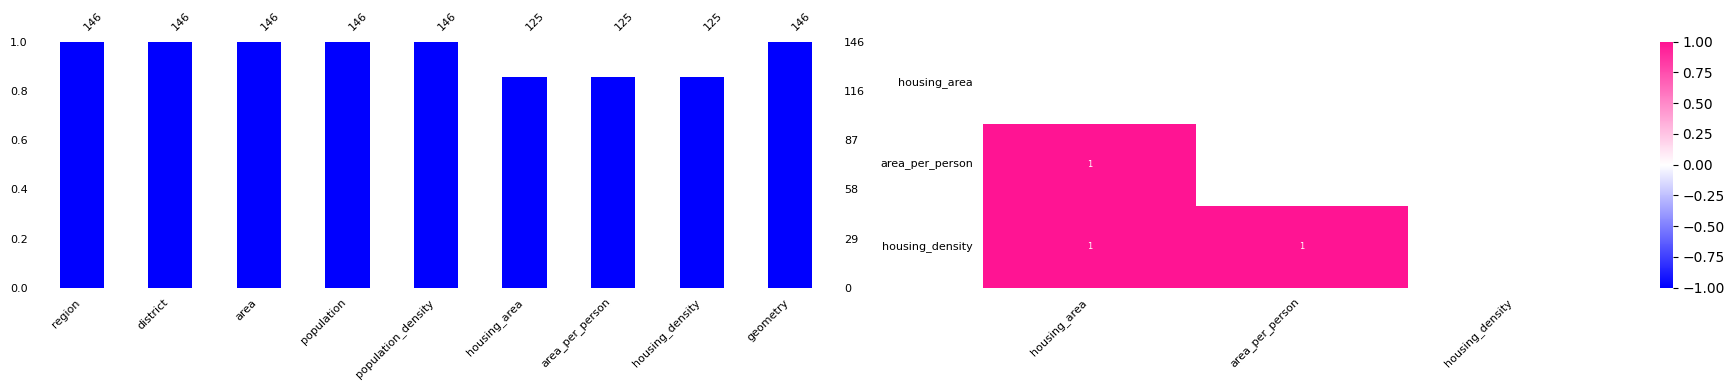

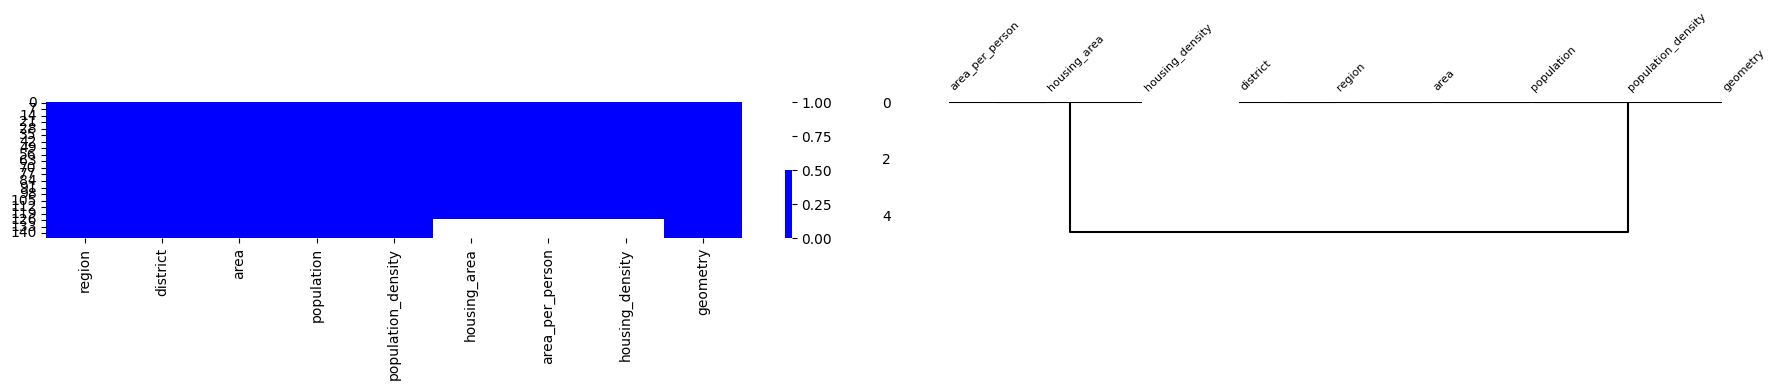

In [14]:
f.describe_data(df_regions_geo) 
f.describe_isna(df_regions_geo, show = True)

In [15]:
# Выводим округа с пустыми значениями
mask = (df_regions_geo['housing_area'].isnull() & df_regions_geo['area_per_person'].isnull() & df_regions_geo['housing_density'].isnull())
items = {'Округа' : 'district', 'Регионы' :'region'}
for item in items:
    print(f"{item} Москвы с пустыми значениями: количество {len(df_regions_geo.loc[mask, items[item]].unique())}, наименования {df_regions_geo.loc[mask, items[item]].unique()}")


Округа Москвы с пустыми значениями: количество 2, наименования ['НАО' 'ТАО']
Регионы Москвы с пустыми значениями: количество 21, наименования ['Внуковское' 'Вороновское' 'Воскресенское' 'Десёновское' 'Киевский'
 'Клёновское' 'Кокошкино' 'Краснопахорское' 'Марушкинское'
 'Михайлово-Ярцевское' 'Московский' 'Мосрентген' 'Новофёдоровское'
 'Первомайское' 'Роговское' 'Рязановское' 'Сосенское' 'Троицк'
 'Филимонковское' 'Щаповское' 'Щербинка']


Данные представлены 12 округам и 146 регионами Москвы.  Данные housing_area, area_per_person, housing_density по 2 округам и их 21 регионам содержат равное количество пустых значений из-за отсутствия этих данных в таблице Википедии. Это данные по поселениям и городским округам. 
Отсутствующих данных менее 20% и почти 5% во всем датасете. Их невозможно заполнить на основе средних значений по округам, так как эти округа (НАО, ТАО) представленны только пустыми значениями в этих столбцах. Можно использовать модели машинного обучения на основе большинства метрик, чтобы восстановить данные. Однако прежде следует уточнить необходимость в этом.
Для лучшего отображения графиков и проверки зависимости метрик данные требуется избавиться от пустых значений и нормализовать данные

##### Визуализация рапределения нумерических данных

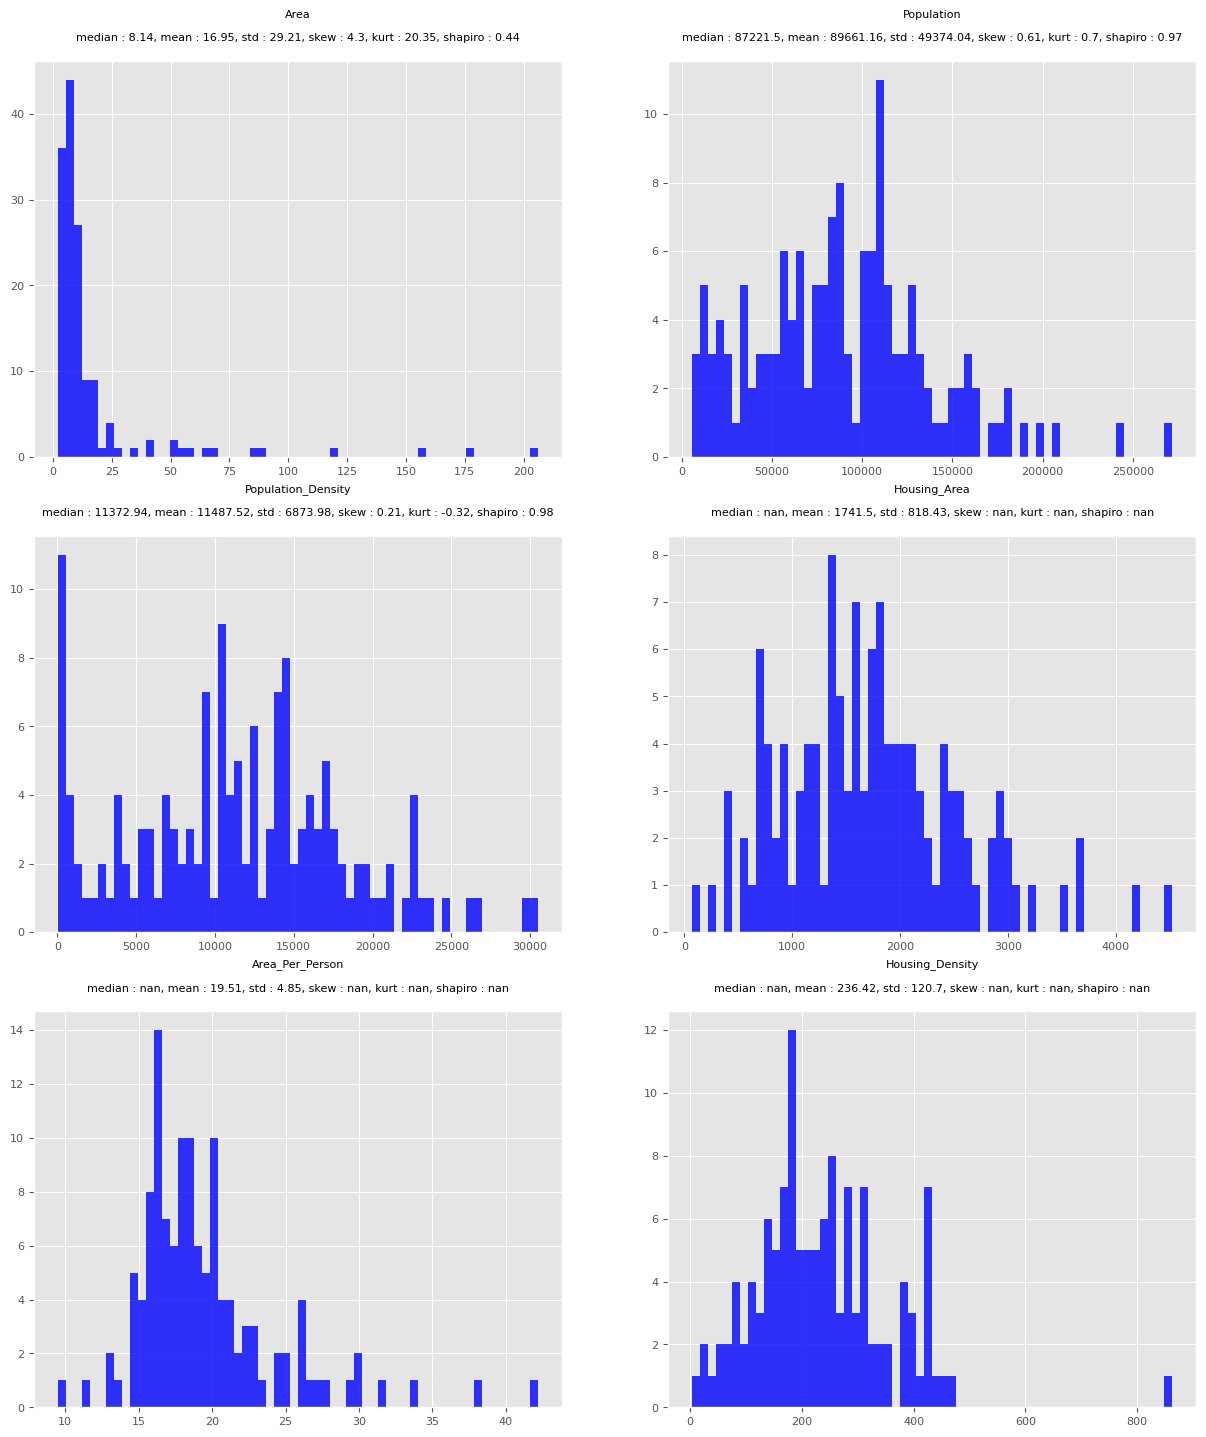

In [16]:
# Строим график распределения нумерических метрик
df_show = df_regions_geo.select_dtypes(include=['number'])
plt.style.use('ggplot')
plt.figure(figsize = (15, 6* len(df_show.columns)))
for i, col in enumerate(df_show.columns):
        plt.subplot(len(df_show.columns), 2, i + 1)
        f.analyze(df_regions_geo[col])
plt.show()

На графике видно особенное смещение влево рапрределения площадей регионов, что говорит о большом диапазоне значений, основная часть которых находится в нижнем сегменте относительное небольших площадей. Большие площади представлены округами (НАО, ТАО), что говорит в пользу их удаления из общей выборки для нормализации данных. Также из-за пустых значений housing_area, area_per_person, housing_density не выводятся отдельные показатели (тест на нормальное распределение данных, ассиметрия, эксцесс).

##### Визуализация в Kepler

In [17]:
# Подготавливаем датафреймы для визуализации и выводим их в Kepler
df_kepler = df_regions_geo.drop(['district', 'area', 'population'], axis = 1)
df_kepler.head()

,region,population_density,housing_area,area_per_person,housing_density,geometry
0,Ростокино,14705.93,732.8,19.7,207.01,"POLYGON ((37.63202 55.83595, 37.63202 55.83694..."
1,Академический,19416.47,2467.0,22.7,423.16,"POLYGON ((37.55226 55.68403, 37.55232 55.68408..."
2,Алексеевский,14839.70,1607.9,20.5,303.95,"POLYGON ((37.63499 55.79714, 37.63552 55.79965..."
3,Алтуфьевский,17154.77,839.3,15.5,258.25,"POLYGON ((37.56740 55.88730, 37.57245 55.88724..."
4,Арбат,17043.60,731.0,26.0,346.45,"POLYGON ((37.57206 55.75202, 37.57396 55.75256..."


In [18]:
# Выводим данные для настройки конфигурации (порядок слоев, размеры, прозрачность и цветовые решения отображения точек и регионов на карте)
# map_ = KeplerGl(height=600, data={"bikeparks": df_bikeparks_geo, "dogparks": df_dogparks_geo, "gyms": df_gyms_geo, "moscow_regions": df_kepler})
# map_

In [19]:
# Сохраняем конфигурацию Kepler (порядок слоев, цветовые решения отображения точек и регионов)
# with open('config/kepler_map.json', 'w') as f:
#     json.dump(map_.config, f)

In [20]:
# Выводим на тепловую карту плотности начеления в регионах Москвы с наложенными точками исследуемой инфраструктуры
with open('config/kepler_map.json') as f:
    config = json.load(f)
map = KeplerGl(height=600, data={"bikeparks": df_bikeparks_geo, "dogparks": df_dogparks_geo, "gyms": df_gyms_geo, "moscow_regions": df_kepler}, config = config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\Art\VSCodeProjects\test\bi_project\venv\lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'x9k0fya', 'type': …

In [21]:
map.save_to_html(file_name="maps/map.html", config=config)

Map saved to maps/map.html!


Визуализация данных с использованием kepler позволяет наглядно представить распределение объектов инфраструктуры по районам Москвы и их соотношение с плотностью населения.
На этой карте представлены регионы Москвы с точками исследуемых объектов (спортзалы, велопарковки и площадки для собак) по описанным выше условиям.  
Цветовой шкалой обозначена плотность населения, где более густонаселенные районы подсвечены красным, слабозаселенные - темно-зеленым.  
На графике видно, что объекты расположены в основном в центре и густонаселенных районах.  
На графике можно выбирать данные по одному виду объектов. Так, можно увидеть, что большое скопление велопарковок находится в пределах Садового кольца, особенно в районах Пресненский, Тверской, Мещанский, Красносельский и Басманный, Якиманка и Замоскворечье. Сосредоточение освещенных площадок для собак преимущественно в районе Якиманка, Аэропорт и Алексеевская. Спортзалы в целом имеют нормальное распределение по карте Москвы, но иногда встречаются кластеры до 7 спортзалов в одном здании. Возможно это разные организации на один объект, и следует объединить их в одну точку. На основе визуализации можно сделать вывод, что район Якиманка является самым обеспеченным с точки зрения исследуемой инфраструктуры.

Заметна большая разница в площадях и представленности инфраструктуры между старыми и новыми округами (НАО, ТАО) Москвы, что говорит о мультимодальности данных и в пользу отдельного анализа для каждого из двух видов округов. Графики распределения это подтверждают. Можно применить статистические инструменты для поиска шумов и аномалий, однако небольшой объем выборки может повлиять на правильность результатов.

Рассмотрим отдельно данные по округам Москвы без округов НАО и ТАО. Также отдельно проанализируем каждый вид объектов. Для этого формируем новый датасет из данных.

### Анализ ночной инфраструктуры регионов Москвы (не включая НАО и ТАО)

##### Описание обновленных данных

In [22]:
import importlib
import functions as f
importlib.reload(f) # используется для обновления модуля без перезапуска всей программы, если в модуль внесены изменения

<module 'functions' from 'c:\\Users\\Art\\VSCodeProjects\\test\\bi_project\\functions.py'>

In [23]:
# Удаление пустых значений (исключение из данных округов НАО и ТАО)
df_regions_geo = df_regions_geo.dropna()

In [24]:
# Смотрим как изменились данные
f.describe_data(df_regions_geo)

,area,population,population_density,housing_area,area_per_person,housing_density
count,125.00,125.00,125.00,125.00,125.00,125.00
mean,8.70,99069.41,13186.57,1741.50,19.51,236.42
std,4.87,45664.45,5902.99,821.73,4.87,121.18
min,2.11,12487.00,573.32,69.90,9.50,3.21
25%,5.38,66564.00,9449.69,1163.50,16.40,157.36
50%,7.84,97658.00,12620.60,1682.40,18.40,223.47
75%,10.40,124527.00,16618.95,2182.00,20.60,308.13
max,27.57,271915.00,30513.93,4523.00,42.20,862.72


,region,district
count,125,125
unique,125,10
top,Ростокино,СВАО
freq,1,17


##### Визуализация рапределения нумерических данных (без пустых значений)

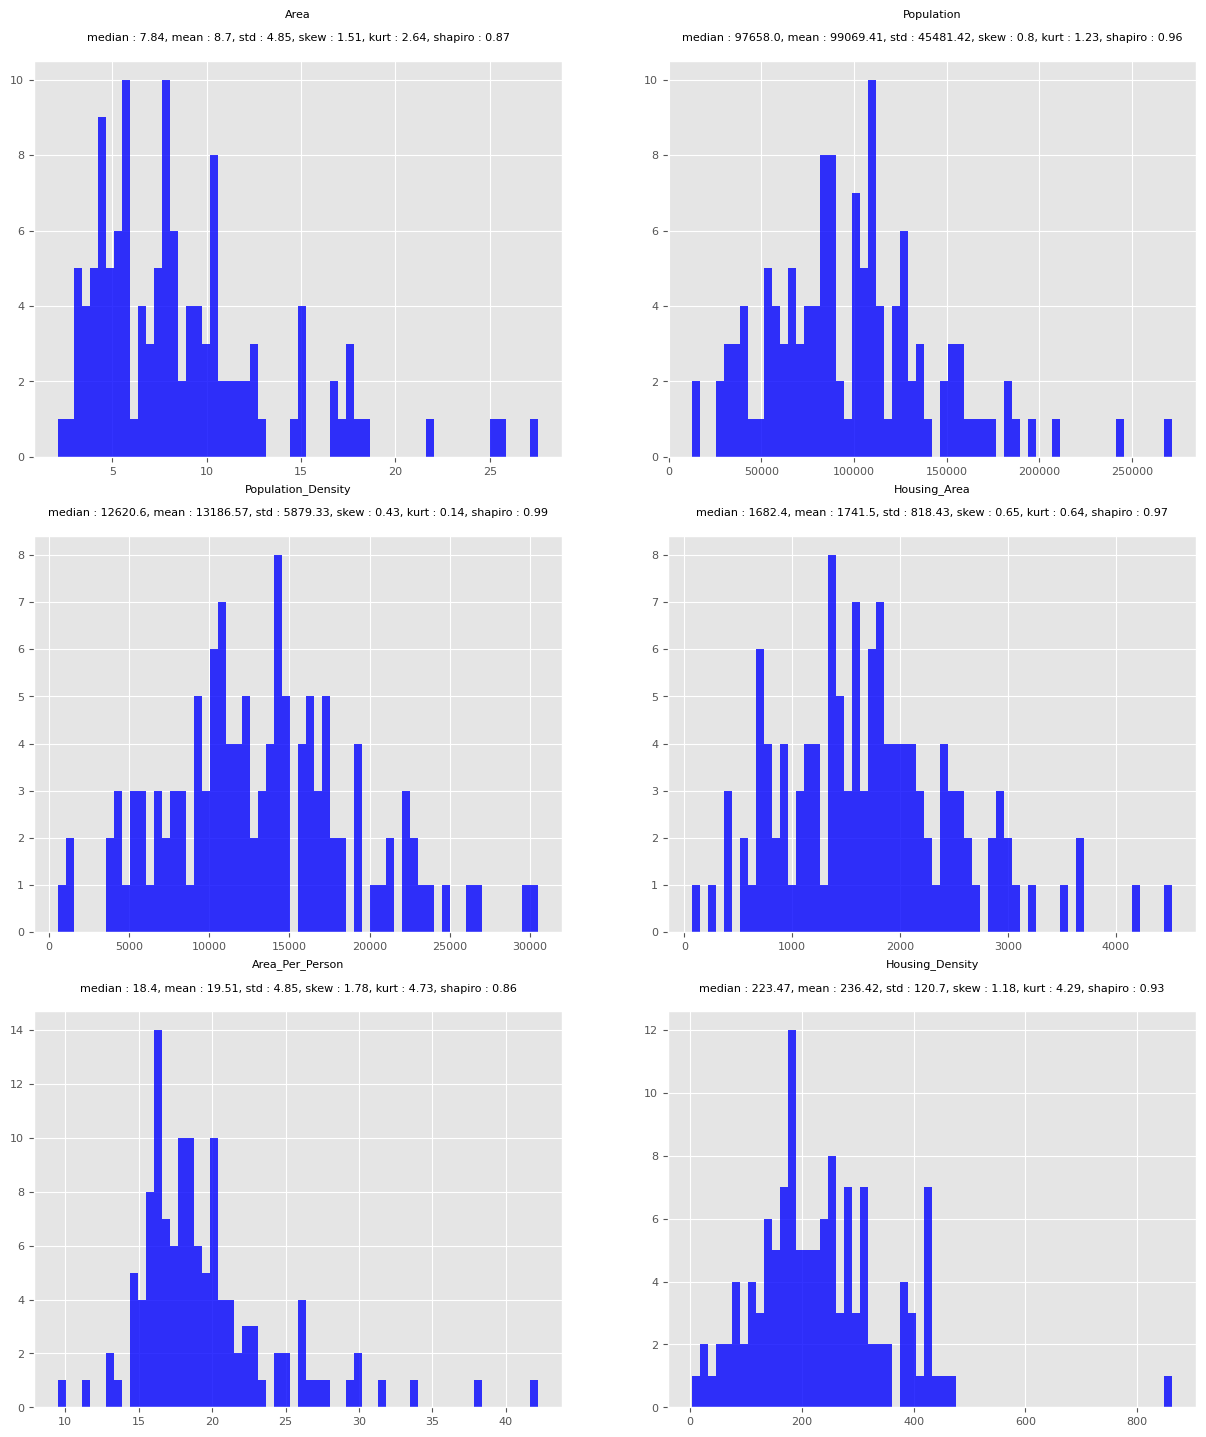

In [25]:
# Строим график распределения нумерических метрик
df_show = df_regions_geo.select_dtypes(include=['number'])
plt.style.use('ggplot')
plt.figure(figsize = (15, 6* len(df_show.columns)))
for i, col in enumerate(df_show.columns):
        plt.subplot(len(df_show.columns), 2, i + 1)
        f.analyze(df_regions_geo[col])
plt.show()

После исключения информации о новых регионах Москвы, распределение данных в метриках приблизилось к нормальному. Тест Шапиро_Уилка не прошли данные по площадям регионов (сосредоточены в диапазоне до 13 кв. км) и по жилой площади на человека (сосредоточены в диапазоне от 14 до 23 кв.м). Они по-прежнему смещены влево.

##### Визуализация топ значений по регионам Москвы

,area
region,
Метрогородок,27.57
Южное Бутово,25.54
Ясенево,25.37
Молжаниновский,21.78
Раменки,18.54


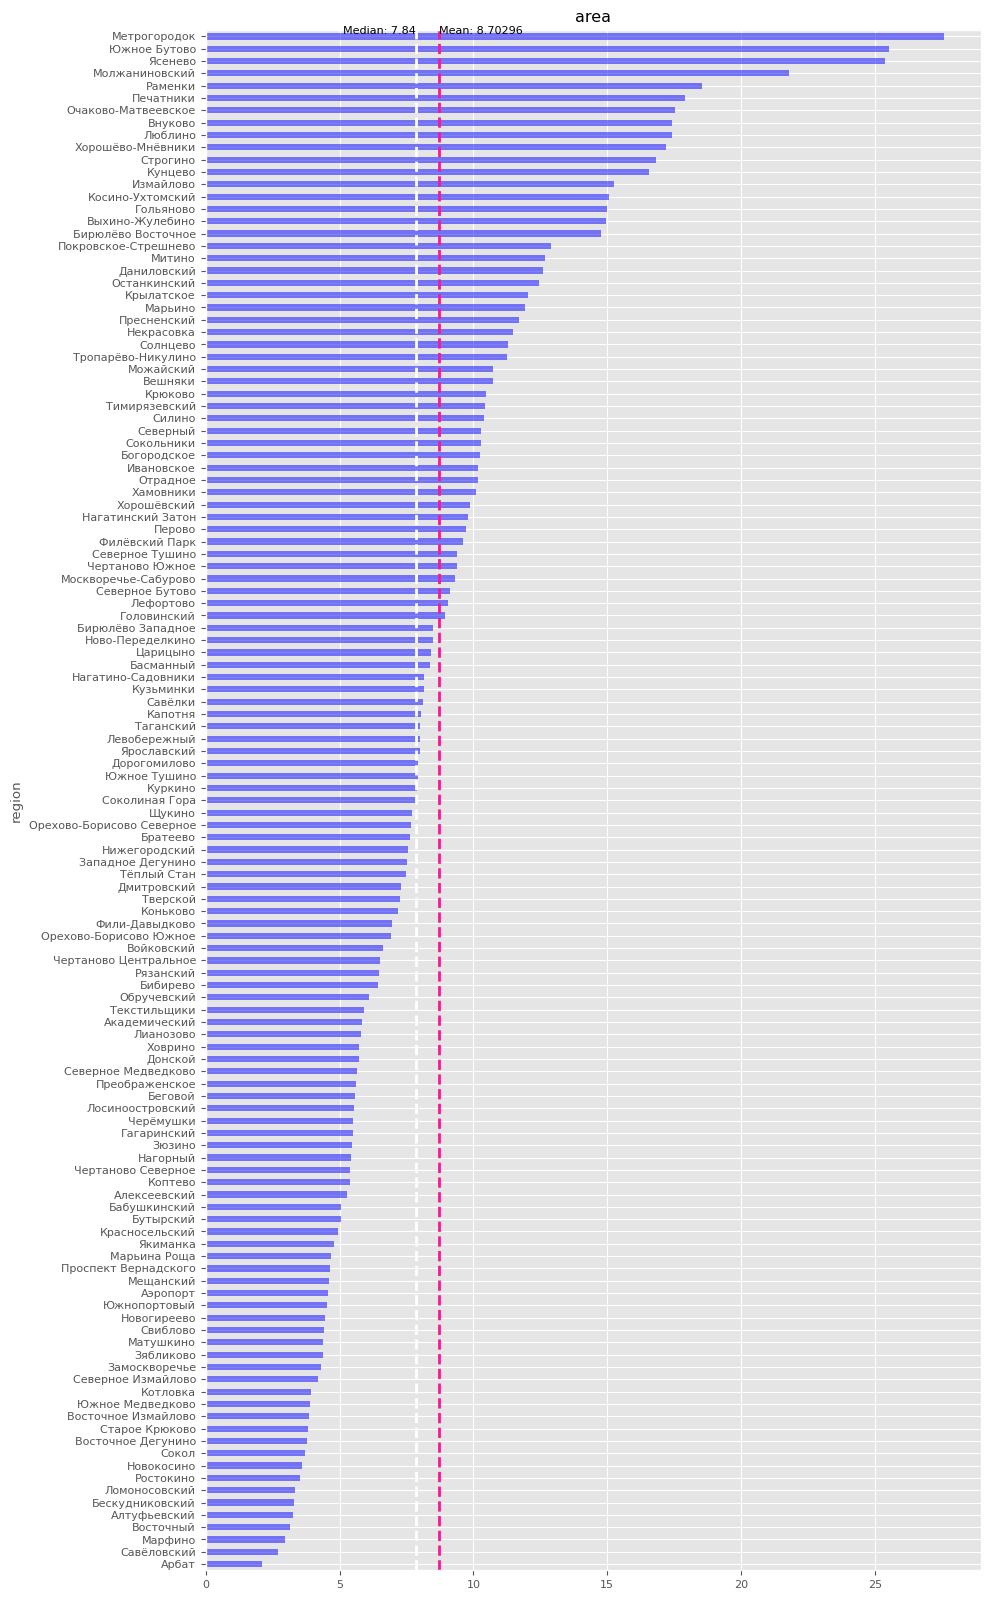

,population
region,
Марьино,271915.0
Выхино-Жулебино,241783.0
Южное Бутово,208783.0
Митино,197840.0
Отрадное,187728.0


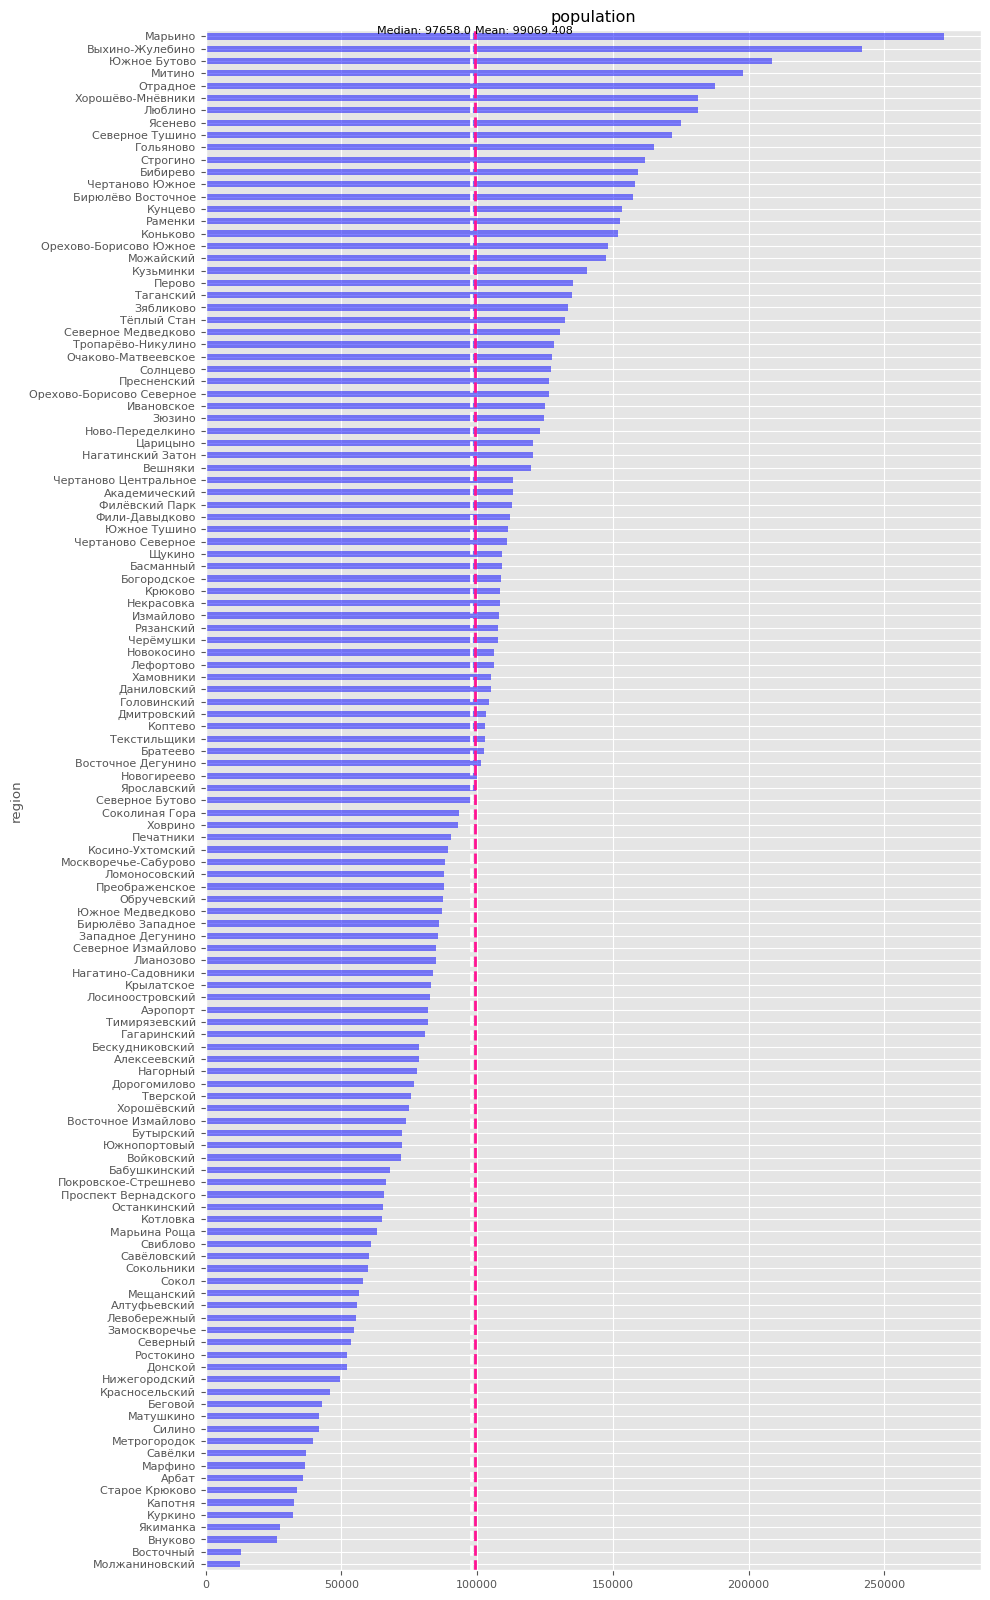

,population_density
region,
Зябликово,30513.93
Новокосино,29533.33
Восточное Дегунино,26949.87
Ломоносовский,26324.25
Бибирево,24704.50


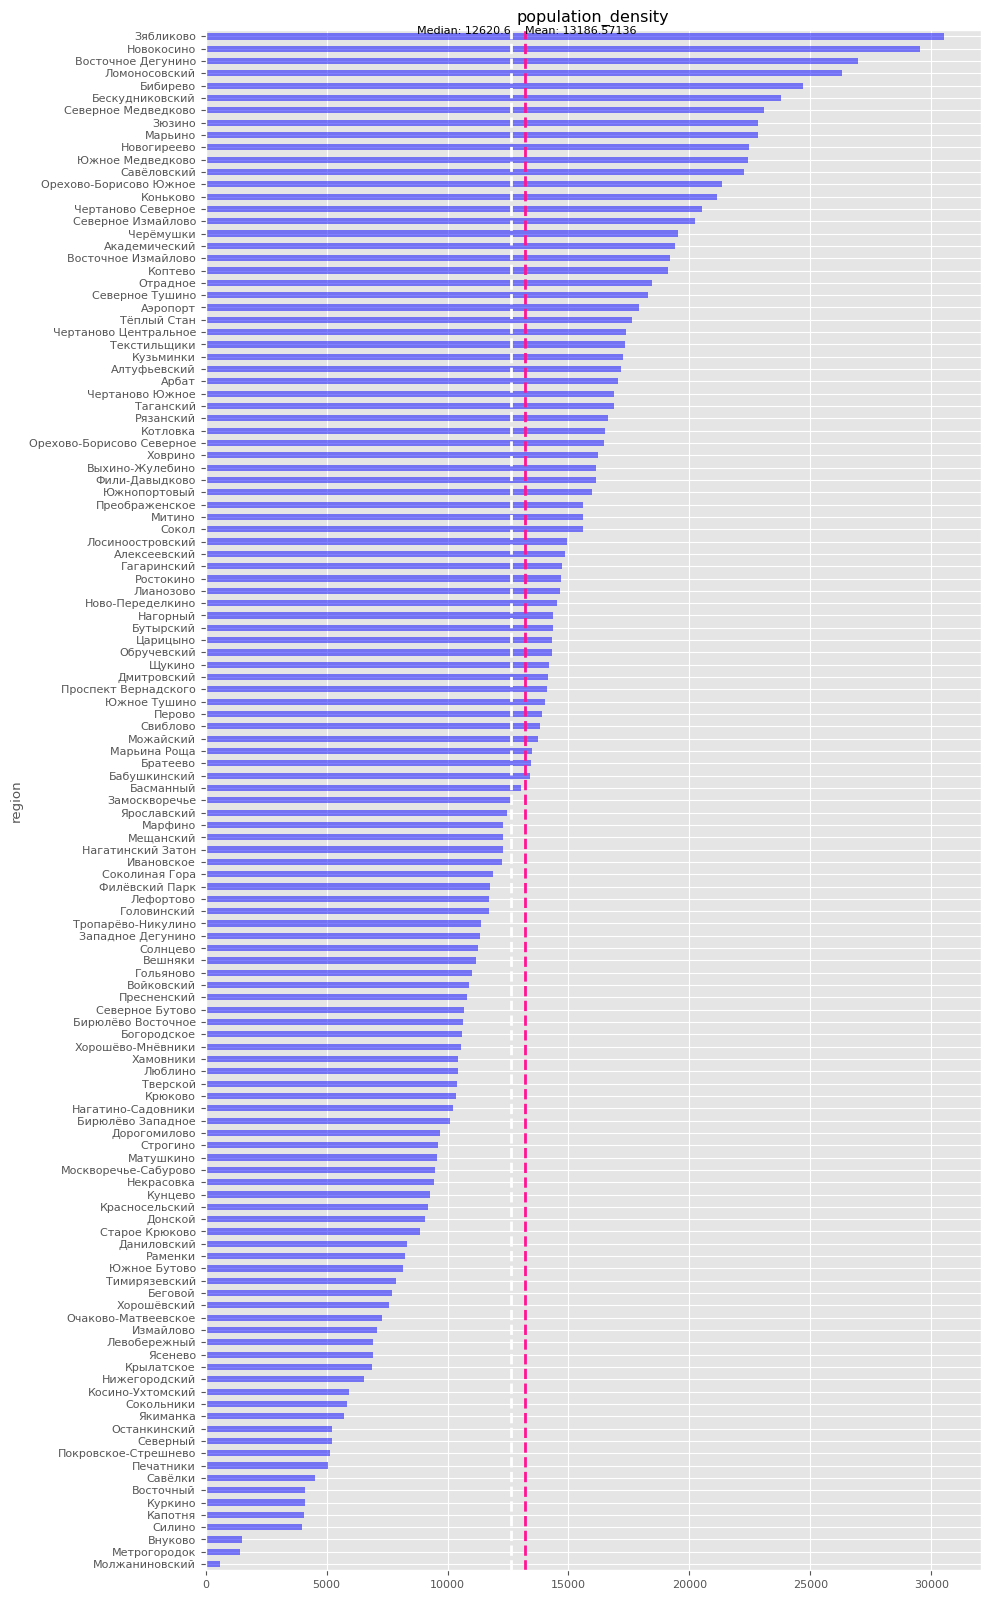

,housing_area
region,
Марьино,4523.0
Южное Бутово,4195.0
Выхино-Жулебино,3704.7
Митино,3658.1
Раменки,3511.2


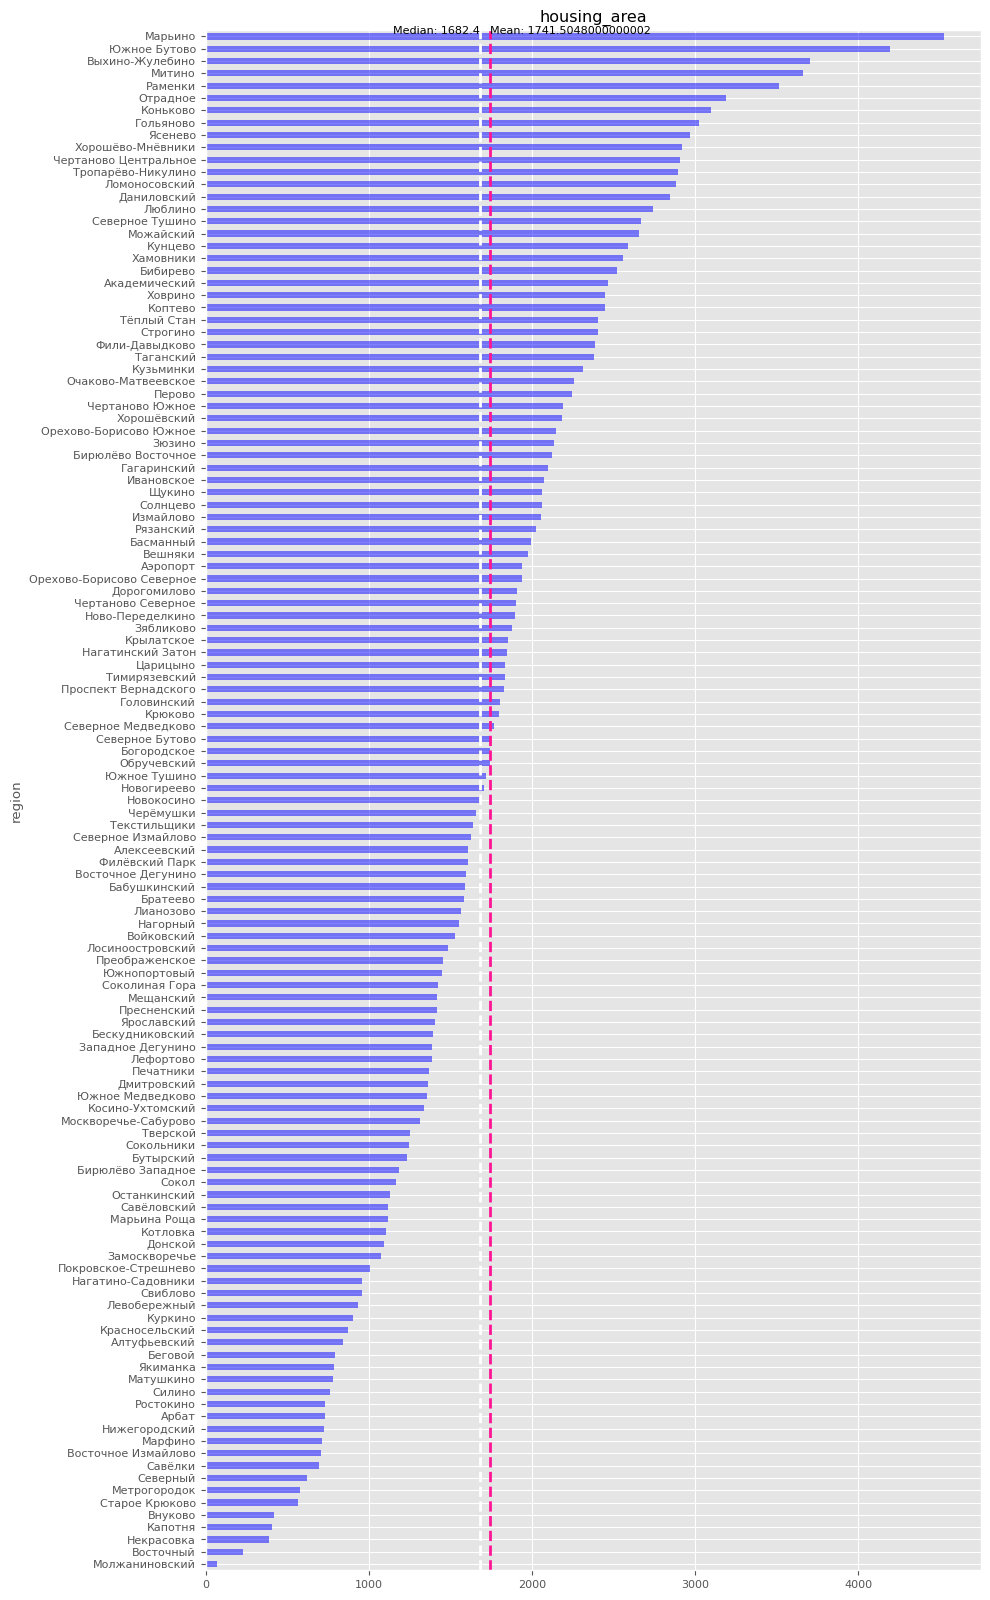

,area_per_person
region,
Куркино,42.2
Хорошёвский,38.2
Ломоносовский,33.9
Даниловский,31.7
Ховрино,30.2


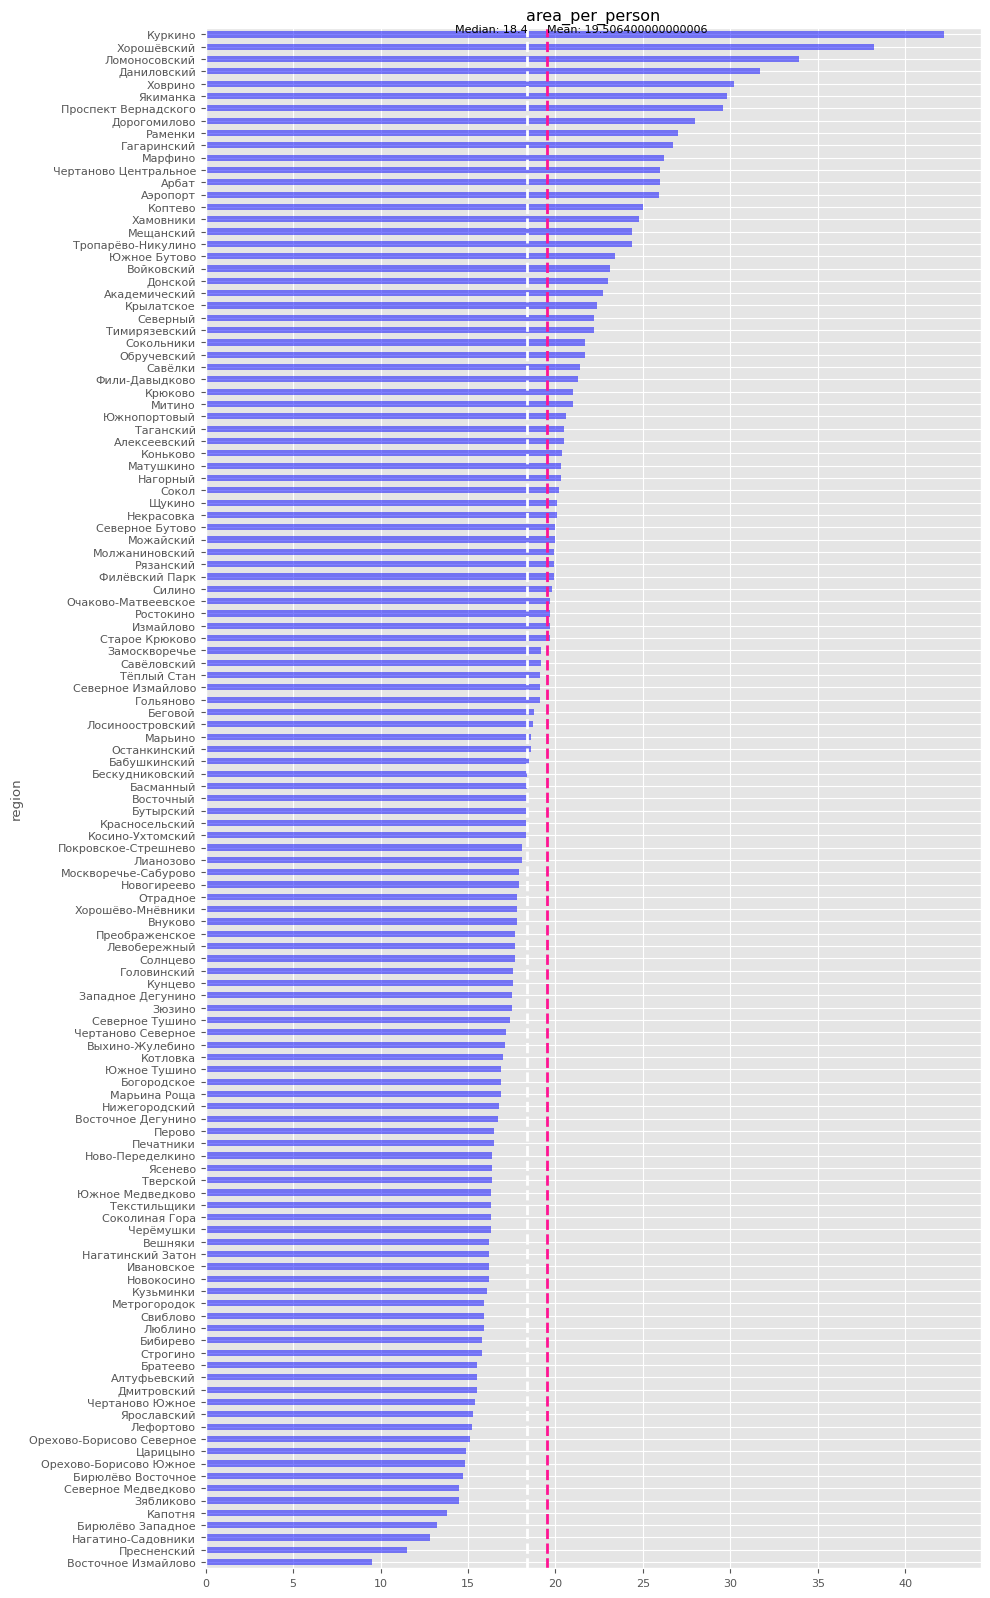

,housing_density
region,
Ломоносовский,862.72
Новокосино,467.33
Коптево,455.35
Чертаново Центральное,445.86
Коньково,431.59


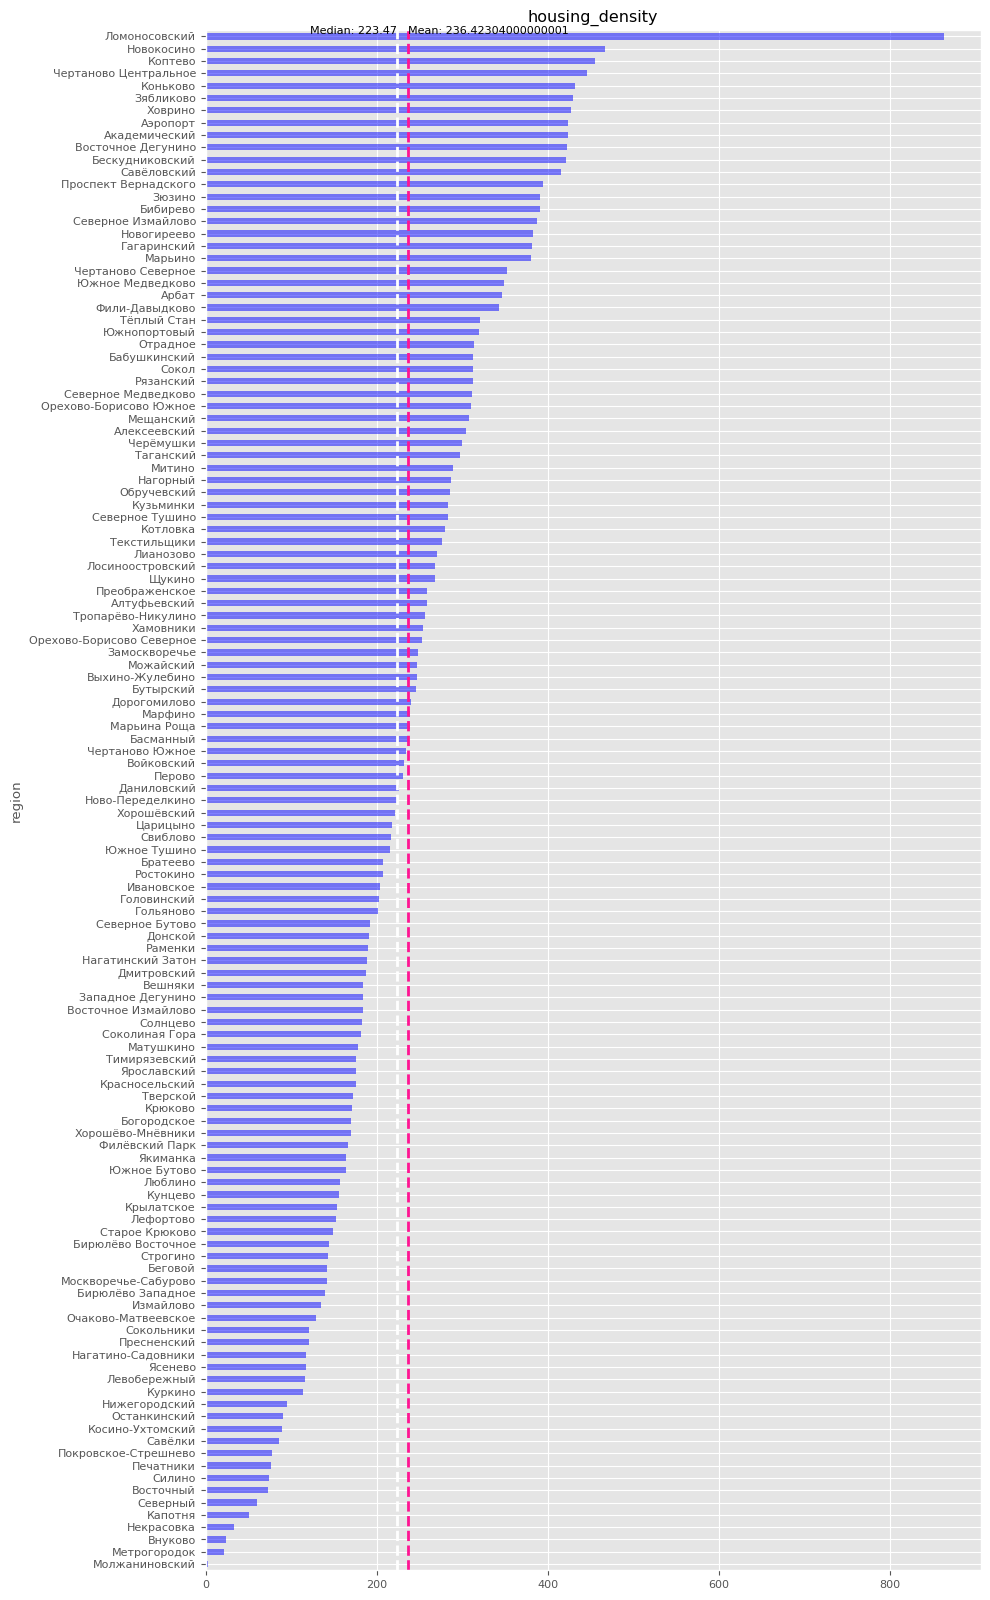

In [26]:
# Выводим топ-5 регионов для каждого показателя и визуализируем все данные
for col in df_regions_geo.select_dtypes(include=['number']).columns:
    df_show = df_regions_geo.set_index('region')
    # display(df_show[df_show[col] == df_show[col].nlargest(3)][['region', col]])
    display(df_show[col].nlargest(5).to_frame())

    df_show = df_regions_geo.set_index('region')
    median_value = df_show[col].median()
    mean_value = df_show[col].mean()
    plt.rcParams['font.size'] = 8
    ax = df_show[col].sort_values().plot.barh(figsize=(10,20), color = 'Blue', alpha = 0.5) #
    ax.text(median_value, len(df_show)-1, f'Median: {median_value}', ha='right', va='bottom', color='black')
    ax.text(mean_value, len(df_show)-1, f'Mean: {mean_value}', ha='left', va='bottom', color='black')

    ax.set_title(f"{col}")
    plt.axvline(median_value, color='White', linestyle='--', linewidth=2)
    plt.axvline(mean_value, color='DeepPink', linestyle='--', linewidth=2)
    plt.show()

Самые большие по площади регионы Метрогородок, Южное Бутово и Ясенево.  
Самая высокая численность населения Марьино и Выхино-Жулебино, а плотность населения особенно ярко выражена в районах Зябликово и Новокосино.

Для районов Куркино и Хорошёвский  характерна большая жилплощадь на человека (42 м.кв и 38 м.кв соответственно). На третьем месте район Ломоносовский (34 м.кв), при этом плотность
застройки района жилыми кварталами сильно отличается в большую сторону (при медианном значении по всем районам 223 составляет 863). Также район Ломоносовский фигурирует в топе по плотности населения, а площадь самого района не высока (находится на седьмом месте с конца). Все это говорит об отсутствии свободных от жилой застройки зон, но возможно компенсируется небольшими размерами и близостью таковых зон в соседних районах.

Бесспорным антилидером по числу и плотности населения, а также по площади и плотности застройки является Молжаниновкий район. Несмотря на удаленность от центра, возможно является самым перспективным из-за близости к аэропорту и транспортной доступности на пути к Зеленограду

Итак, предположим, что критериями удобного для жилья района можно считать большую жилплощадь, среднюю плотность населения и также среднюю плотность застройки жилыми кварталами (с зелеными зонами парками, без промзон и тд.). Построим визуализацию на основе этих критериев.


In [27]:
# Подготавливаем датафреймы для визуализации и выводим их в Kepler
df_kepler = df_regions_geo.drop(['district', 'area', 'population'], axis = 1)

# # Выводим данные для настройки конфигурации (порядок слоев, размеры, прозрачность и цветовые решения отображения точек и регионов на карте)
# map_ = KeplerGl(height=600, data={"moscow_regions": df_kepler})
# map_

In [28]:
# # Сохраняем конфигурацию Kepler (порядок слоев, цветовые решения отображения точек и регионов)
# with open('config/kepler_map_housing_density_vs_area_per_person.json', 'w') as f:
#     json.dump(map_.config, f)

In [29]:
# Выводим на тепловую карту плотности начеления в регионах Москвы с наложенными точками исследуемой инфраструктуры
with open('config/kepler_map_housing_density_vs_area_per_person.json') as f:
    config = json.load(f)
map = KeplerGl(height=600, data={"moscow_regions": df_kepler}, config = config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '3wmdllv', 'type': …

In [30]:
map.save_to_html(file_name="maps/map_housing_density_vs_area_per_person.html", config=config)

Map saved to maps/map_housing_density_vs_area_per_person.html!


Районы Куркино и Хорошевский имеют одновременно хорошие показатели по плотности застройки и жилплощади на человека, при этом плотность застройки в Хорошевском районе в два раза выше, но сам район значительно ближе к центру города.


##### Подготовка данных объектов для геоматчинга с регионами

In [31]:
import importlib
import functions as f
importlib.reload(f) # используется для обновления модуля без перезапуска всей программы, если в модуль внесены изменения

<module 'functions' from 'c:\\Users\\Art\\VSCodeProjects\\test\\bi_project\\functions.py'>

In [32]:
# Выводим ошибки несовпадения регионов при геоматчинге по координатам
dict_df_geo = {"bikeparks": df_bikeparks_geo, "dogparks": df_dogparks_geo, "gyms": df_gyms_geo} #, "moscow_regions": df_kepler
for key in dict_df_geo:
    print(f'Датасет {key}')
    f.find_region_diff(df_regions_geo, dict_df_geo[key])

Датасет bikeparks


region_left         region_right         
Алексеевский        Останкинский район        1
Алтуфьевский        Войковский район          1
Басманный           Таганский район           1
Войковский          район Лефортово           1
Даниловский         Южнопортовый район        1
                    район Кузьминки           1
Зюзино              Нагорный район            1
Котловка            район Выхино-Жулебино     1
Красносельский      Басманный район          16
Крылатское          Басманный район           2
Ломоносовский       Гагаринский район         1
Мещанский           Красносельский район      2
                    Тверской район            2
Можайский           поселение Московский      1
Нижегородский       Рязанский район           1
Силино              район Старое Крюково      1
Тверской            Мещанский район           1
                    Пресненский район         8
Тимирязевский       Бутырский район           1
Тропарёво-Никулино  район Раменки             

Датасет dogparks


Series([], dtype: int64)

Датасет gyms


region_left   region_right   
Южнопортовый  район Печатники    1
dtype: int64

Видно, что в датасете по площадкам для собак все регионы совпали, а больше всего несовпадений в датасете по велопарковкам. После просмотра точек на карте, выявились неоднозначности определения региона. Для более детального исследования можно снова запросить данные с data.mos.ru уже с адресами и сравнить место их попадания на карте. Пока будем придерживаться соответствия местоположения точки региону по координатам.

In [33]:
# # Сравниваем соответствие регионов из двух таблиц
# df_compare  = df_join[['region_left', 'region_right']].drop_duplicates()

In [34]:
# Формируем новые датасеты для визуализации по выбранным регионам Москвы и удобства анализа данных
df_bikeparks_match = f.geomatching(df_regions_geo, df_bikeparks_geo)
df_dogparks_match = f.geomatching(df_regions_geo, df_dogparks_geo)
df_gyms_match = f.geomatching(df_regions_geo, df_gyms_geo)

##### Построение отчета об обеспеченности ночной инфраструктурой регионов Москвы

In [35]:
# Построение отчета о количестве людей на каждый объект и объектов на человека
df_gyms_match['obj_count'] = df_gyms_match.groupby('region_left')['index_right'].transform('nunique')
df_gyms_people_per_obj = df_gyms_match[['region_left', 'population', 'obj_count']].drop_duplicates() #.sort_values('obj_count', ascending = False)
df_gyms_people_per_obj['people_per_obj'] = df_gyms_people_per_obj['population'] / df_gyms_people_per_obj['obj_count']
df_gyms_people_per_obj['obj_per_person'] = df_gyms_people_per_obj['obj_count'] / df_gyms_people_per_obj['population']

print('Спортзалы')
print('Самые обеспеченные районы')
display(df_gyms_people_per_obj.sort_values('obj_per_person', ascending = False).head())
print('Самые необеспеченные районы')
display(df_gyms_people_per_obj.sort_values('obj_per_person', ascending = True).head())

Спортзалы
Самые обеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
122,Якиманка,27481.0,20,1374.050000,0.000728
86,Савёловский,60070.0,22,2730.454545,0.000366
101,Тверской,75593.0,26,2907.423077,0.000344
8,Беговой,42729.0,14,3052.071429,0.000328
108,Хамовники,105275.0,33,3190.151515,0.000313


Самые необеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
34,Ивановское,125042.0,2,62521.000000,0.000016
3,Алтуфьевский,55753.0,1,55753.000000,0.000018
11,Бирюлёво Восточное,157292.0,3,52430.666667,0.000019
119,Южное Медведково,86996.0,2,43498.000000,0.000023
76,Очаково-Матвеевское,127680.0,3,42560.000000,0.000023


In [36]:
# Построение отчета о количестве людей на каждый объект и объектов на человека
df_dogparks_match['obj_count'] = df_dogparks_match.groupby('region_left')['index_right'].transform('nunique')
df_dogparks_people_per_obj = df_dogparks_match[['region_left', 'population', 'obj_count']].drop_duplicates() #.sort_values('obj_count', ascending = False)
df_dogparks_people_per_obj['people_per_obj'] = df_dogparks_people_per_obj['population'] / df_dogparks_people_per_obj['obj_count']
df_dogparks_people_per_obj['obj_per_person'] = df_dogparks_people_per_obj['obj_count'] / df_dogparks_people_per_obj['population']

print('Площадки для собак')
print('Самые обеспеченные районы')
display(df_dogparks_people_per_obj.sort_values('obj_per_person', ascending = False).head())
print('Самые необеспеченные районы')
display(df_dogparks_people_per_obj.sort_values('obj_per_person', ascending = True).head())

Площадки для собак
Самые обеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
122,Якиманка,27481.0,10,2748.100000,0.000364
63,Нагатино-Садовники,83658.0,8,10457.250000,0.000096
47,Левобережный,55355.0,5,11071.000000,0.000090
5,Аэропорт,81964.0,7,11709.142857,0.000085
2,Алексеевский,78502.0,6,13083.666667,0.000076


Самые необеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
52,Люблино,181447.0,1,181447.0,0.000006
124,Ясенево,175253.0,1,175253.0,0.000006
10,Бибирево,159344.0,1,159344.0,0.000006
100,Таганский,135106.0,1,135106.0,0.000007
33,Зябликово,133651.0,1,133651.0,0.000007


Если рассматривать велопарковки с учетом их мест (атрибут capacity), то ситуация изменится, и на первый план выйдет район Якиманка, что подтверждает предыдущие выводы.

In [37]:
# Построение отчета о количестве людей на каждый объект и объектов на человека
df_bikeparks_match['obj_count'] = df_bikeparks_match.groupby('region_left')['capacity'].transform('sum')
df_bikeparks_people_per_obj = df_bikeparks_match[['region_left', 'population', 'obj_count']].drop_duplicates() #.sort_values('obj_count', ascending = False)
df_bikeparks_people_per_obj['people_per_obj'] = df_bikeparks_people_per_obj['population'] / df_bikeparks_people_per_obj['obj_count']
df_bikeparks_people_per_obj['obj_per_person'] = df_bikeparks_people_per_obj['obj_count'] / df_bikeparks_people_per_obj['population']

print('Веломеста')
print('Самые обеспеченные районы')
display(df_bikeparks_people_per_obj.sort_values('obj_per_person', ascending = False).head())
print('Самые необеспеченные районы')
display(df_bikeparks_people_per_obj.sort_values('obj_per_person', ascending = True).head())

Веломеста
Самые обеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
122,Якиманка,27481.0,134,205.082090,0.004876
101,Тверской,75593.0,322,234.760870,0.004260
41,Красносельский,45691.0,167,273.598802,0.003655
81,Пресненский,126433.0,328,385.466463,0.002594
4,Арбат,35962.0,86,418.162791,0.002391


Самые необеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
76,Очаково-Матвеевское,127680.0,6,21280.000000,0.000047
55,Марьино,271915.0,16,16994.687500,0.000059
44,Кузьминки,140670.0,16,8791.875000,0.000114
45,Кунцево,153316.0,18,8517.555556,0.000117
106,Филёвский Парк,113015.0,14,8072.500000,0.000124


Примечание: велопарковки некорректно рассматривать с точки зрения ночной инфраструктуры города из-за отсутсвия данных о часах работы, следовательно считаем, что все велопарковки работают круглосуточно. Для визуализации оставим данные о количестве велопарковок (не веломест) на душу населения

In [38]:
# Построение отчета о количестве людей на каждый объект и объектов на человека
df_bikeparks_match['obj_count'] = df_bikeparks_match.groupby('region_left')['index_right'].transform('nunique')
df_bikeparks_people_per_obj = df_bikeparks_match[['region_left', 'population', 'obj_count']].drop_duplicates() #.sort_values('obj_count', ascending = False)
df_bikeparks_people_per_obj['people_per_obj'] = df_bikeparks_people_per_obj['population'] / df_bikeparks_people_per_obj['obj_count']
df_bikeparks_people_per_obj['obj_per_person'] = df_bikeparks_people_per_obj['obj_count'] / df_bikeparks_people_per_obj['population']

print('Велопарковки')
print('Самые обеспеченные районы')
display(df_bikeparks_people_per_obj.sort_values('obj_per_person', ascending = False).head())
print('Самые необеспеченные районы')
display(df_bikeparks_people_per_obj.sort_values('obj_per_person', ascending = True).head())

Велопарковки
Самые обеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
41,Красносельский,45691.0,41,1114.414634,0.000897
101,Тверской,75593.0,64,1181.140625,0.000847
122,Якиманка,27481.0,19,1446.368421,0.000691
7,Басманный,109051.0,74,1473.662162,0.000679
4,Арбат,35962.0,20,1798.100000,0.000556


Самые необеспеченные районы


,region_left,population,obj_count,people_per_obj,obj_per_person
55,Марьино,271915.0,2,135957.5,0.000007
76,Очаково-Матвеевское,127680.0,1,127680.0,0.000008
45,Кунцево,153316.0,2,76658.0,0.000013
44,Кузьминки,140670.0,2,70335.0,0.000014
87,Свиблово,60984.0,1,60984.0,0.000016


In [39]:
# Формируем датафрейм для визуализации структуры размезщения объектов в регионах
df_structure =  df_gyms_people_per_obj[['region_left', 'obj_per_person']].rename(columns={'obj_per_person' : 'gym_per_person'}).\
    merge(df_dogparks_people_per_obj[['region_left', 'obj_per_person']].rename(columns={'obj_per_person' : 'dogpark_per_person'})).\
        merge(df_bikeparks_people_per_obj[['region_left', 'obj_per_person']].rename(columns={'obj_per_person' : 'bikepark_per_person'})).\
            rename(columns={'region_left' : 'region'}).\
                set_index('region')
df_structure = df_structure.assign(total = df_structure['gym_per_person'] + df_structure['dogpark_per_person'] + df_structure['bikepark_per_person']).sort_values('total') # столбец total для сортировки на основе сумм всех значений в строках
df_structure.head()
            

,gym_per_person,dogpark_per_person,bikepark_per_person,total
region,,,,
Очаково-Матвеевское,0.000023,0.000023,0.000008,0.000055
Северное Тушино,0.000029,0.000012,0.000035,0.000076
Щукино,0.000027,0.000018,0.000037,0.000082
Крюково,0.000046,0.000009,0.000028,0.000083
Академический,0.000044,0.000009,0.000035,0.000088


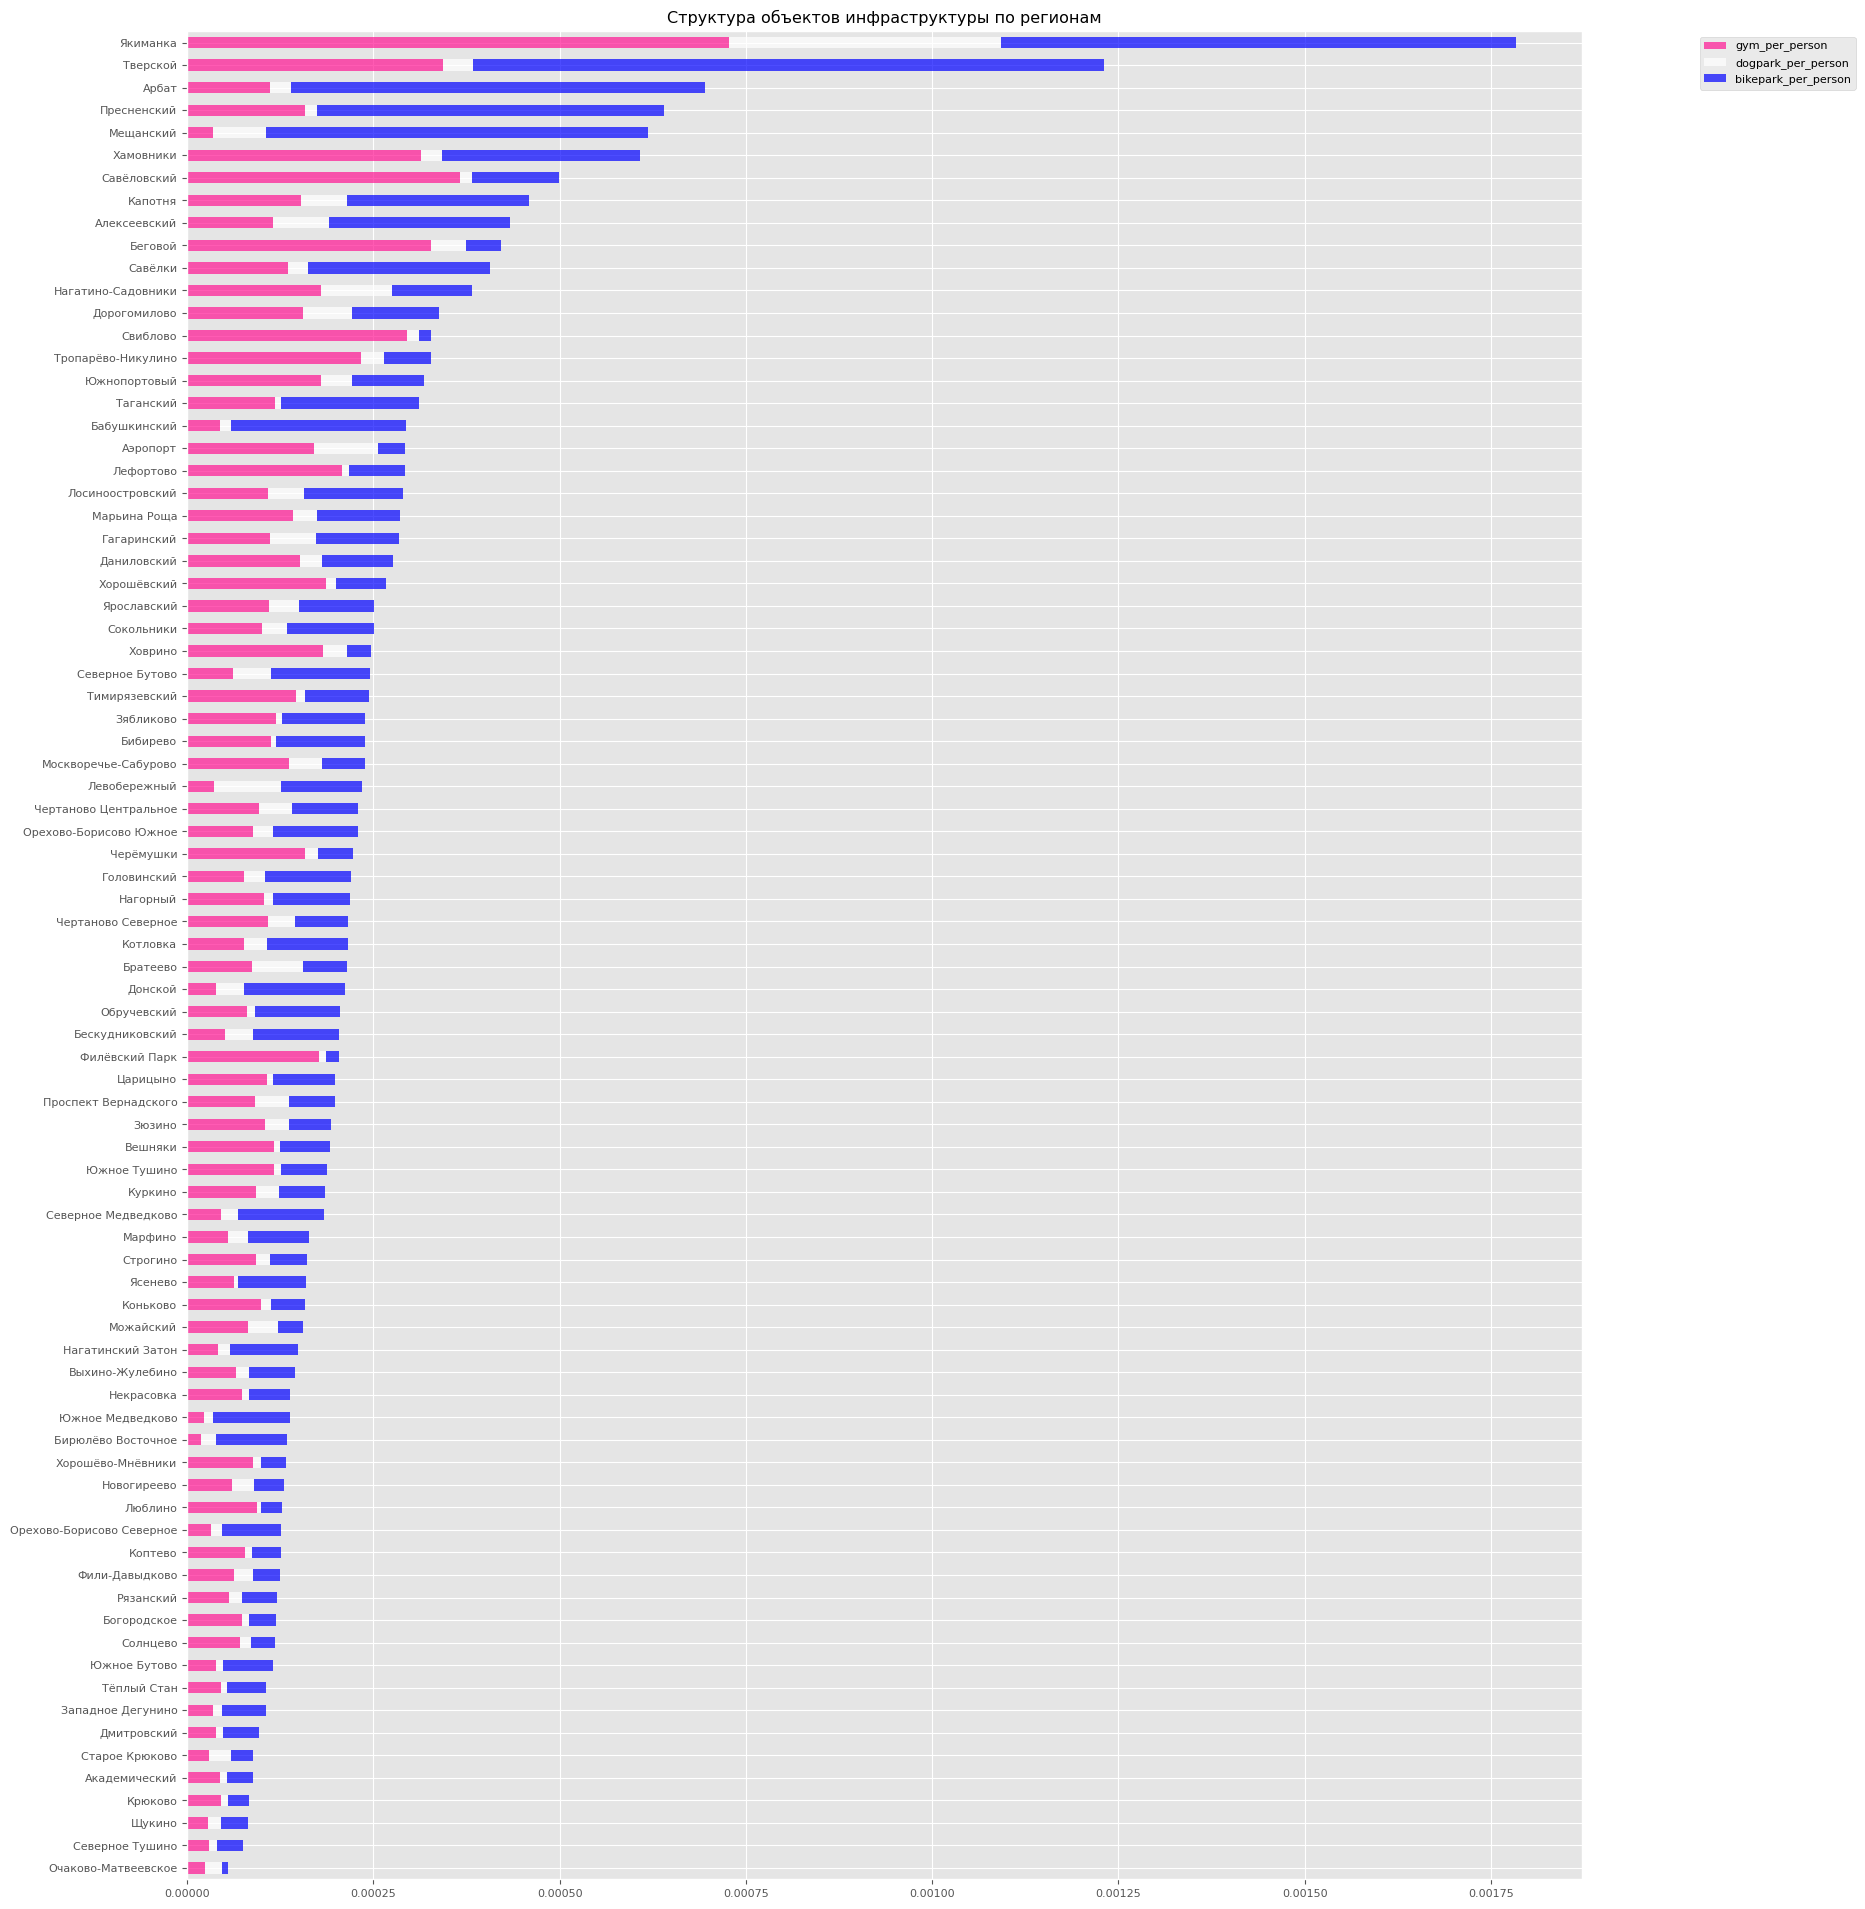

In [41]:
# Функция визуализации структуры объектов по регионам
def show_structure(df):
        plt.rcParams['font.size'] = 8
        ax = df_structure.drop('total', axis = 1).plot.barh(figsize=(18,24), stacked=True, title='Структура объектов инфраструктуры по регионам', color=['DeepPink', 'White', 'Blue'], alpha=0.7) #
        ax.legend(loc=1, bbox_to_anchor=(1.2, 1))
        ax.set(ylabel=None, xlabel=None)
        plt.show()
show_structure(df_structure)

Анализ данных показал, что самые обеспеченные исследуемой инфраструктурой районы Москвы Якиманка и Тверской. При этом некоторые районы имеют недостаточное количество спортзалов, велопарковок и площадок для собак относительно плотности населения и жилой площади. Это может свидетельствовать о неравномерном распределении инфраструктуры и необходимости дополнительных инвестиций в развитие соответствующих объектов.


##### Дополнительные возможности для развития проекта
Проект можно дополнять исследованиями инфраструктуры Москвы с помощью других датасетов с портала Портала открытых данных правительства Москвы, интегрировать с иными источниками данных для получения более полной картины об инфраструктуре Москвы. Например, на основе данных общепита, гостиниц и отелей, досуга и развлечений, медицины и образования, общественного транспорта и заправок, детских площадок и магазинов. С помощью обезличенных данных о продажах, сезонности продаж или проходимости выявляются закономерности трат населения в определенных геозонах. Таким образом можно сделать выводы об обеспеченности районов инфраструктурой в целом.